In [1]:
# Veri okuma ve işleme
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

# Uyarıları kapatma
import warnings
warnings.filterwarnings("ignore")

# Model Değerlendirme
from sklearn.metrics import classification_report, confusion_matrix

# Model Kurma
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

## Verisetinin Okunması

veriseti linki: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification

In [65]:
dir_path = "Garbage_Classification" # Klasör yolu

In [66]:
target_size = (224, 224) # görsel boyutu

waste_labels = {"cardboard":0, "glass":1, "metal":2, "paper":3, "plastic":4, "trash":5}
waste_labels_1 = {0:"cardboard", 1:"glass", 2:"metal", 3:"paper", 4:"plastic", 5:"trash"}

In [74]:
# görsellerin ve etiketlerin alınması
def load_datasets(path):

    x = []
    labels = []

    image_paths = sorted(list(paths.list_images(path)))

    for image_path in image_paths:
        img = cv2.imread(image_path)

        img = cv2.resize(img, target_size)

        x.append(img)

        label = image_path.split(os.path.sep)[-2]

        labels.append(waste_labels[label])

        x, labels = shuffle(x, labels, random_state=42)

    print(f"X boyutu: {np.array(x).shape}")
    print(f"Label boyutu: {len(labels)}")
    print(f"Label sınıf sayısı: {len(np.unique(labels))}")

    return x, labels

In [5]:
X, labels = load_datasets(dir_path)

X boyutu: (2527, 224, 224, 3)
Label boyutu: 2527
Label sınıf sayısı: 6


In [75]:
# görselleri 3 kanallı olacak şekilde boyutlandırma
input_shape = (np.array(X).shape[-3], np.array(X).shape[-2], np.array(X).shape[-1])
input_shape

(224, 224, 3)

In [76]:
# birkaç görsel ve etiketlerini görselleştirme
def visualize_img(image_batch, label_batch, num):
    plt.figure(figsize=(10, 10))
    for n in range(num):
        plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(waste_labels_1[labels[n]])
        plt.axis("off")

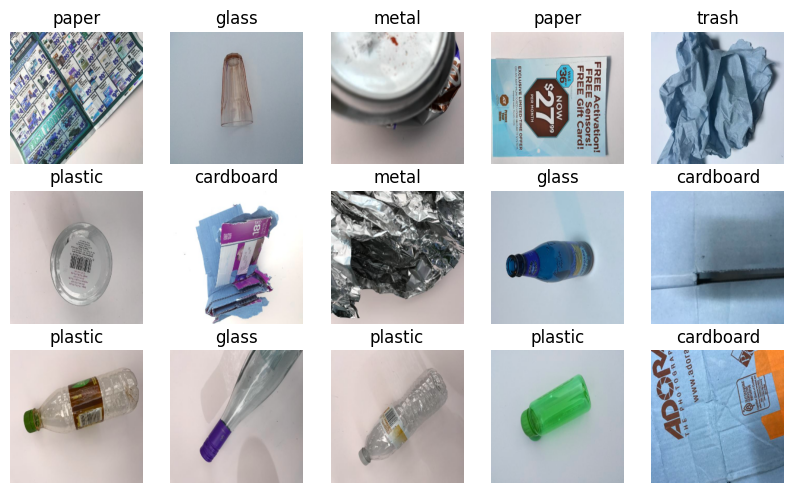

In [8]:
visualize_img(X, labels, 15)

## Veri Artırma (Data Augmentation)

In [78]:
# elimizdeki görsellerden yeni görseller üretmek için ayarları belirleme
train = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.1,
    rescale = 1/255,
    shear_range = 0.1,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1
    )
# test görselleri için sadece normalizasyon ve validasyon oranı belirleme
test = ImageDataGenerator(
    rescale = 1/255, # görsellerin her bir noktadaki değerini 0-1 arasına oranlar
    validation_split = 0.1
)

In [79]:
# belirlediğimiz ayarlar ile generator oluşturma
train_generator = train.flow_from_directory(
    directory = dir_path,
    target_size = target_size,
    class_mode = "categorical",
    subset = "training" # eğitim verisi
)

test_generator = test.flow_from_directory(
    directory = dir_path,
    target_size = target_size,
    batch_size = 251, 
    class_mode = "categorical",
    subset = "validation" # test verisi
)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


## CNN Modeli Kurma
1. Sequential
2. Evrişim Katmanı (Convolution Layer)
3. Havuzlama Katmanı (Pooling Layer)
4. Aktivasyon Fonksiyonu (Activation Function)
5. Flattening Katmanı
6. Dense Katmanı
7. Dropout Katmanı

In [80]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", input_shape=input_shape, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())

model.add(Dense(units=64, activation="relu"))
model.add(Dropout(rate=0.2))

model.add(Dense(units=32, activation="relu"))
model.add(Dropout(rate=0.2))

model.add(Dense(units=6, activation="softmax"))
# 6 adet sınıf olduğu için 6 çıkış birimi
# çoklu sınıflandırma yaptığımız için softmax aktivasyon fonksiyonu

## CNN Model Mimarisi

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 32)        0

## Optimizasyon ve Değerlendirme Ölçülerinin Ayarlanması

In [13]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"]
)

In [14]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=50, mode="min", verbose=1),
    ModelCheckpoint(filepath="recycle.h5", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=False, verbose=1)
]

## Modelin Eğitilmesi

In [15]:
history = model.fit_generator(
    generator = train_generator,
    epochs = 100,
    validation_data = test_generator,
    callbacks = callbacks,
    workers = 4,
    steps_per_epoch = 2276//32,
    validation_steps = 251//32
)

Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 1.7016 - precision: 0.5645 - recall: 0.0156 - acc: 0.2420
Epoch 1: val_loss improved from inf to 1.56964, saving model to recycle.h5
71/71 [==============================] - 41s 566ms/step - loss: 1.7016 - precision: 0.5645 - recall: 0.0156 - acc: 0.2420 - val_loss: 1.5696 - val_precision: 0.9000 - val_recall: 0.0359 - val_acc: 0.3546
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 1.5361 - precision: 0.7079 - recall: 0.0994 - acc: 0.3512
Epoch 2: val_loss improved from 1.56964 to 1.44179, saving model to recycle.h5
71/71 [==============================] - 42s 593ms/step - loss: 1.5361 - precision: 0.7079 - recall: 0.0994 - acc: 0.3512 - val_loss: 1.4418 - val_precision: 0.9062 - val_recall: 0.1155 - val_acc: 0.3665
Epoch 3/100
71/71 [==============================] - ETA: 0s - loss: 1.4490 - precision: 0.7442 - recall: 0.1426 - acc: 0.3881
Epoch 3: val_loss did not improve from 1.44179
71/71 [===

## Accuracy ve Loss Grafikleri

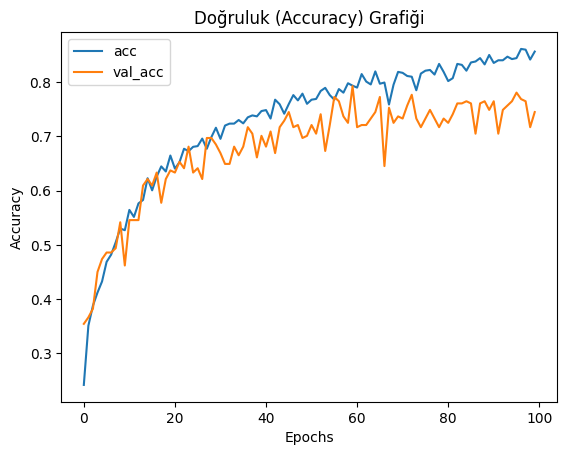

In [16]:
acc = pd.DataFrame(history.history)[["acc","val_acc"]]
acc.plot()
plt.title("Doğruluk (Accuracy) Grafiği")
plt.xlabel("Epochs")
plt.ylabel("Accuracy");

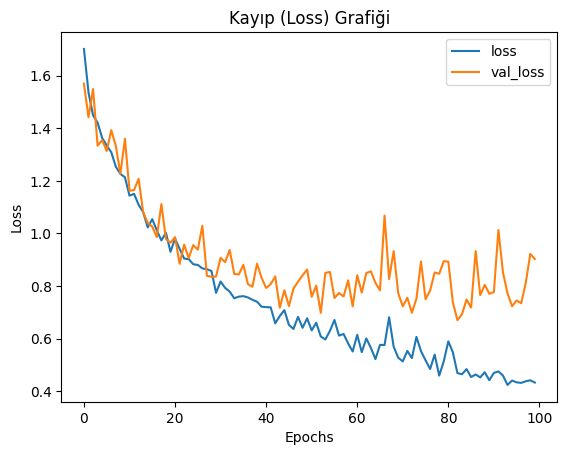

In [17]:
loss = pd.DataFrame(history.history)[["loss","val_loss"]]
loss.plot()
plt.title("Kayıp (Loss) Grafiği")
plt.xlabel("Epochs")
plt.ylabel("Loss");

## Model Değerlendirme (Evaluation)

In [18]:
loss, precision, recall, acc = model.evaluate(test_generator, batch_size=3)

1/1 [==============================] - 1s 962ms/step - loss: 0.9029 - precision: 0.7900 - recall: 0.6892 - acc: 0.7450


In [19]:
print(f"Loss: {loss*100:.2f}% \nPrecision: {precision*100:.2f}% \nRecall: {recall*100:.2f}% \nAccuracy: {acc*100:.2f}%")

Loss: 90.29% 
Precision: 79.00% 
Recall: 68.92% 
Accuracy: 74.50%


In [20]:
images, labels = test_generator.next()

In [21]:
y_pred = model.predict(images)

8/8 [==============================] - 1s 93ms/step


In [22]:
y_pred = [np.argmax(i) for i in y_pred]

In [23]:
labels = [np.argmax(i) for i in labels]

In [24]:
confusion_matrix(labels, y_pred)

array([[28,  1,  7,  1,  2,  1],
       [ 0, 42,  6,  1,  1,  0],
       [ 0,  8, 31,  0,  2,  0],
       [ 0,  1,  3, 55,  0,  0],
       [ 2, 11,  4,  7, 23,  1],
       [ 0,  2,  1,  2,  0,  8]], dtype=int64)

In [25]:
print(classification_report(labels, y_pred, target_names=waste_labels))

              precision    recall  f1-score   support

   cardboard       0.93      0.70      0.80        40
       glass       0.65      0.84      0.73        50
       metal       0.60      0.76      0.67        41
       paper       0.83      0.93      0.88        59
     plastic       0.82      0.48      0.61        48
       trash       0.80      0.62      0.70        13

    accuracy                           0.75       251
   macro avg       0.77      0.72      0.73       251
weighted avg       0.77      0.75      0.74       251



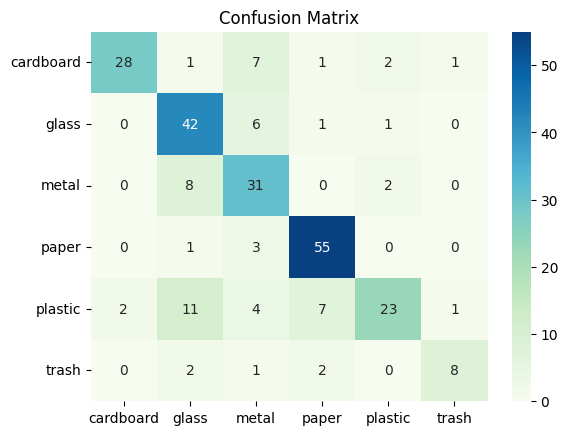

In [26]:
sns.heatmap(confusion_matrix(labels, y_pred), annot=True, xticklabels=waste_labels.keys(), yticklabels=waste_labels.keys(), cmap="GnBu")
plt.yticks(rotation=0)
plt.title("Confusion Matrix");

## Modeli Kullanma

In [27]:
waste_model = load_model("recycle.h5")

In [83]:
def predict_images(path):
    
    # path: görsellerin dizini

    images = []
    classes = []
    probs = []

    image_paths = sorted(list(paths.list_images(path)))
    image_paths = shuffle(image_paths)[:6] # rastgele 6 görsel seç

    for img_path in image_paths:
        img = image.load_img(img_path, target_size=(224, 224)) 
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0 

        predictions = waste_model.predict(img_array, verbose=0)
        predicted_class_index = np.argmax(predictions) # en yüksek oranın indexini verir
        predicted_class_prob = np.max(predictions) # en yüksek oranı verir
        class_name = waste_labels_1[predicted_class_index] 
        # bulunan index ile başta belirlediğimiz sözlükten sınıf adını alme

        images.append(img_array)
        classes.append(class_name)
        probs.append(predicted_class_prob)

    return images, classes, probs

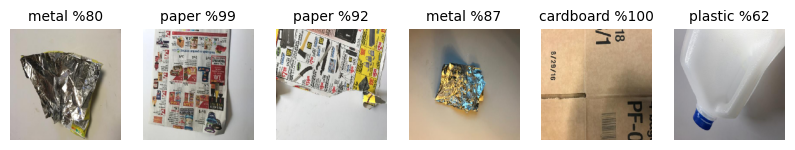

In [82]:
# tahmin edilen görselleri, sınıfları ve olasıklarını görselleştirme
images, classes, probs = predict_images(dir_path)
plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(images[i].squeeze())
    plt.title(f"{classes[i]} %{probs[i]*100:.0f}", fontsize=10)
    plt.axis("off")